In [1]:
import tensorflow as tf
try: #If running in colab 
    import google.colab
    IN_COLAB = True 
except:
    IN_COLAB = False
if (not tf.__version__.startswith('2')): #Checking if tf 2.0 is installed
    if IN_COLAB: #If running in colab install tf 2.0
        !pip install tensorflow-gpu==2.0.0-alpha0
        !pip install tfp-nightly==0.7.0-dev20190511
    print('Please install tensorflow 2.0 to run this notebook')
print('Tensorflow version: ',tf.__version__, ' running in colab?: ', IN_COLAB)

Tensorflow version:  2.0.0-alpha0  running in colab?:  True


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook as tqdm
import urllib.request
from sklearn.model_selection import train_test_split
import tensorflow_probability as tfp


%matplotlib inline
plt.style.use('default')

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)
np.random.seed(42)
tf.random.set_seed(42)


TFP Version 0.7.0-dev20190511
TF  Version 2.0.0-alpha0


In [0]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

170500096/170498071 [==============================] - 13s 0us/step


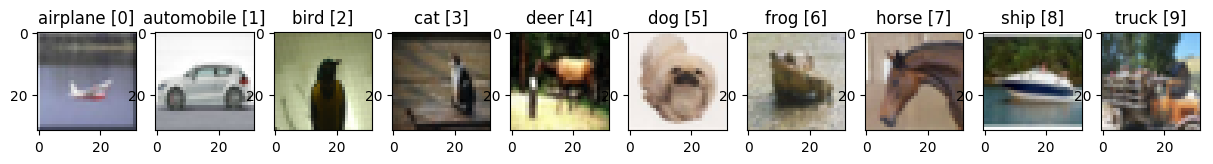

In [5]:
labels=np.array(["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"])
#sample image of each label
plt.figure(figsize=(15,15))
for i in range(0,len(np.unique(y_train))):
    rmd=np.random.choice(np.where(y_train==i)[0],1)
    plt.subplot(1,10,i+1)
    img=x_train[rmd]
    plt.imshow(img[0,:,:,:])
    plt.title(labels[i]+" "+np.str(y_train[rmd][0]))

In [0]:
#we delete all horses of the dataset
y_train_no_horse=np.delete(y_train,np.where(y_train==7)[0])
x_train_no_horse=np.delete(x_train,np.where(y_train==7)[0],axis=0)

In [7]:
print(y_train_no_horse.shape)
print(x_train_no_horse.shape)

(45000,)
(45000, 32, 32, 3)


In [0]:
y_train_no_horse=np.array(pd.get_dummies(y_train_no_horse))
labels_no_horse=np.array(["airplane","automobile","bird","cat","deer","dog","frog","ship","truck"])


In [9]:
print(y_train_no_horse.shape)

(45000, 9)


In [0]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train_no_horse, y_train_no_horse, test_size=0.4, random_state=22)


In [11]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(27000, 32, 32, 3)
(27000, 9)
(18000, 32, 32, 3)
(18000, 9)
(10000, 32, 32, 3)
(10000, 1)


In [0]:
## tf norm
x_train=((x_train/255)-0.5)*2
x_val=((x_val/255)-0.5)*2
x_test=((x_test/255)-0.5)*2

## Baseline "normal" CNN

In [13]:
from tensorflow.keras.layers import Convolution2D,MaxPooling2D,Dropout,Flatten,Dense
from tensorflow.keras import Sequential

model = Sequential()
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model.add(MaxPooling2D((2,2)))
model.add(Flatten())
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(100, activation = 'relu'))
model.add(Dropout((0.5)))
model.add(Dense(9, activation = 'softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 8)         224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0

In [0]:
# history=model.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=50,verbose=1)
# nach  30 epochs overfitting

In [0]:
## plt.figure(figsize=(12,5))
## plt.subplot(1,2,1)
## plt.plot(history.history['accuracy'])
## plt.plot(history.history['val_accuracy'])
## plt.ylim(0, 1)
## plt.title('model accuracy')
## plt.ylabel('accuracy')
## plt.xlabel('epoch')
## plt.legend(['train', 'valid'], loc='lower right')
## plt.subplot(1,2,2)
## plt.plot(history.history['loss'])
## plt.plot(history.history['val_loss'])
## plt.title('model loss')
## plt.ylabel('loss')
## plt.xlabel('epoch')
## plt.legend(['train', 'valid'], loc='upper right')
## plt.show()

In [0]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_cifar10_weights.hdf5", "model_cifar10_weights.hdf5")
model.load_weights("model_cifar10_weights.hdf5")

## Variational Inference

In [17]:


kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (x_train.shape[0] * 1.0)
model_vi = Sequential()
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn,input_shape=(32,32,3)))
model_vi.add(tfp.layers.Convolution2DFlipout(8,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.Convolution2DFlipout(16,kernel_size=(3,3),padding="same", activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tf.keras.layers.MaxPooling2D((2,2)))
model_vi.add(tf.keras.layers.Flatten())
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(100, activation = 'relu', kernel_divergence_fn=kernel_divergence_fn))
model_vi.add(tfp.layers.DenseFlipout(9, activation = 'softmax', kernel_divergence_fn=kernel_divergence_fn))

model_vi.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
model_vi.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_flipout (Conv2DFlipou (None, 32, 32, 8)         440       
_________________________________________________________________
conv2d_flipout_1 (Conv2DFlip (None, 32, 32, 8)         1160      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_flipout_2 (Conv2DFlip (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_flipout_3 (Conv2DFlip (None, 16, 16, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)             

In [18]:
for i in range(0,5):
  print(model_vi.predict(x_train[0:1])[0])
#we get a different pred at every run!

[0.09463479 0.09075084 0.06524865 0.12114819 0.20404676 0.13459481
 0.09199314 0.08309227 0.11449052]
[0.10224642 0.09068009 0.12060899 0.14144282 0.20617001 0.06855081
 0.07573756 0.10327561 0.09128777]
[0.10128574 0.14290309 0.09355497 0.09164041 0.15786473 0.10743263
 0.09387702 0.07437591 0.13706554]
[0.08030448 0.16678122 0.07890403 0.11879602 0.12737443 0.07932717
 0.11303148 0.08091666 0.15456456]
[0.1174884  0.12215862 0.0891941  0.1277566  0.1676999  0.06517433
 0.0860345  0.07605997 0.14843354]


In [0]:
# history=model_vi.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=400,verbose=1)
# need a lot of epochs
# longer training would maybe give some improvement

In [0]:
## plt.figure(figsize=(12,5))
## plt.subplot(1,2,1)
## plt.plot(history.history['accuracy'])
## plt.plot(history.history['val_accuracy'])
## plt.ylim(0, 1)
## plt.title('model accuracy')
## plt.ylabel('accuracy')
## plt.xlabel('epoch')
## plt.legend(['train', 'valid'], loc='lower right')
## plt.subplot(1,2,2)
## plt.plot(history.history['loss'])
## plt.plot(history.history['val_loss'])
## plt.title('model loss')
## plt.ylabel('loss')
## plt.xlabel('epoch')
## plt.legend(['train', 'valid'], loc='upper right')
## plt.show()

In [0]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_vi_cifar10_weights.hdf5", "model_vi_cifar10_weights.hdf5")
model_vi.load_weights("model_vi_cifar10_weights.hdf5")

## MC Dropout

In [22]:
#def MCDropout(rate):
#    return tf.keras.layers.Lambda(lambda x: tf.keras.backend.dropout(x, level=rate))

model_mc = Sequential()
model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu',input_shape=(32,32,3)))
model_mc.add(Dropout((0.3)))
model_mc.add(Convolution2D(8,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(MaxPooling2D((2,2)))
model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(Convolution2D(16,kernel_size=(3,3),padding="same", activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(MaxPooling2D((2,2)))
model_mc.add(Flatten())
model_mc.add(Dense(100, activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(Dense(100, activation = 'relu'))
model_mc.add(Dropout((0.3)))
model_mc.add(Dense(9, activation = 'softmax'))

model_mc.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model_mc.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 8)         224       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 8)         584       
_________________________________________________________________
dropout_3 (Dropout)          (None, 32, 32, 8)         0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 8)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 16)        1168      
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 16)       

In [0]:
import tensorflow.keras.backend as K
#f = K.function([model_mc.input], [model_mc.output])
model_mc_pred = K.function([model_mc.input, K.learning_phase()], [model_mc.output])



In [25]:
#no dropout at test time
for i in range(0,5):
  print(model_mc_pred([x_train[0:1],0])[0])

[[0.10756771 0.10821912 0.10264864 0.08194333 0.11125134 0.12981907
  0.11575696 0.11045896 0.13233489]]
[[0.10756771 0.10821912 0.10264864 0.08194333 0.11125134 0.12981907
  0.11575696 0.11045896 0.13233489]]
[[0.10756771 0.10821912 0.10264864 0.08194333 0.11125134 0.12981907
  0.11575696 0.11045896 0.13233489]]
[[0.10756771 0.10821912 0.10264864 0.08194333 0.11125134 0.12981907
  0.11575696 0.11045896 0.13233489]]
[[0.10756771 0.10821912 0.10264864 0.08194333 0.11125134 0.12981907
  0.11575696 0.11045896 0.13233489]]


In [26]:
#dropout at test time
for i in range(0,5):
  print(model_mc_pred([x_train[0:1],1])[0])

[[0.05340284 0.08013184 0.02720378 0.01406597 0.03608416 0.52601194
  0.0465527  0.03041479 0.186132  ]]
[[0.09000062 0.14094238 0.11339027 0.03373798 0.07706576 0.29862112
  0.12265133 0.04732518 0.07626529]]
[[0.12636015 0.06951004 0.09832671 0.00935495 0.15459016 0.12035031
  0.22326386 0.06927208 0.12897173]]
[[0.12729846 0.06210142 0.14784107 0.02489884 0.03650108 0.26300696
  0.16329442 0.06904203 0.10601578]]
[[0.06042549 0.07850865 0.08656283 0.04354087 0.0863023  0.11806371
  0.10779461 0.1733124  0.24548915]]


In [0]:
#history=model_mc.fit(x_train, y_train,validation_data=(x_val,y_val), batch_size=128,epochs=400,verbose=1)

In [0]:
## plt.figure(figsize=(12,5))
## plt.subplot(1,2,1)
## plt.plot(history.history['accuracy'])
## plt.plot(history.history['val_accuracy'])
## plt.ylim(0, 1)
## plt.title('model accuracy')
## plt.ylabel('accuracy')
## plt.xlabel('epoch')
## plt.legend(['train', 'valid'], loc='lower right')
## plt.subplot(1,2,2)
## plt.plot(history.history['loss'])
## plt.plot(history.history['val_loss'])
## plt.title('model loss')
## plt.ylabel('loss')
## plt.xlabel('epoch')
## plt.legend(['train', 'valid'], loc='upper right')
## plt.show()

In [0]:
# download and load weights of the model
urllib.request.urlretrieve("https://raw.githubusercontent.com/tensorchiefs/dl_book/master/data/model_mc_cifar10_weights.hdf5", "model_mc_cifar10_weights.hdf5")
model_mc.load_weights("model_mc_cifar10_weights.hdf5")

## Acc on the lables in the train set for all three models
VI and MC 50 preds und then argmax of mean

In [31]:
known_idx=np.where(y_test!=7)[0]
print(len(known_idx))
x_test_known = x_test[known_idx]
y_test_known = y_test[known_idx]

unknown_idx=np.where(y_test==7)[0]
print(len(unknown_idx))
x_test_unknown = x_test[unknown_idx]
y_test_unknown = y_test[unknown_idx]

9000
1000


In [32]:
pred_baseline=np.argmax(model.predict(x_test_known),axis=1)
pred_label=np.array([labels_no_horse[np.int(pred_baseline[i])] for i in range(0,len(pred_baseline))])
true_label=np.array([labels[np.int(y_test_known[i])] for i in range(0,len(y_test_known))])
print("test_acc_on_known_lables =",np.sum(pred_label==true_label)/len(true_label) )
test_acc_known = np.sum(pred_label==true_label)/len(true_label)


test_acc_on_known_lables = 0.6632222222222223


In [33]:
# 50 pred and then mean and argmax for the val set
SET=x_test_known
pred_vi=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_vi[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class

In [34]:
pred_label=np.array([labels_no_horse[np.int(pred_vi[i])] for i in range(0,len(pred_vi))])
true_label=np.array([labels[np.int(y_test_known[i])] for i in range(0,len(y_test_known))])
print("test_acc_on_known_lables =",np.sum(pred_label==true_label)/len(true_label) )
test_acc_known_vi = np.sum(pred_label==true_label)/len(true_label)


test_acc_on_known_lables = 0.6786666666666666


In [35]:
# 50 pred and then mean and argmax for the val set
SET=x_test_known
pred_mc=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_mc[i]=np.argmax(np.mean(preds,axis=1))#mean over n runs of every proba class

In [37]:
pred_label=np.array([labels_no_horse[np.int(pred_mc[i])] for i in range(0,len(pred_mc))])
true_label=np.array([labels[np.int(y_test_known[i])] for i in range(0,len(y_test_known))])
print("test_acc_on_known_lables =",np.sum(pred_label==true_label)/len(true_label) )
test_acc_known_mc = np.sum(pred_label==true_label)/len(true_label)


test_acc_on_known_lables = 0.7207777777777777


In [38]:
import pandas as pd
pd.DataFrame(np.column_stack([test_acc_known,test_acc_known_vi,test_acc_known_mc]), index=['test acc on known labels'],columns=['baseline','VI','MC'])

,baseline,VI,MC
test acc on known labels,0.663222,0.678667,0.720778


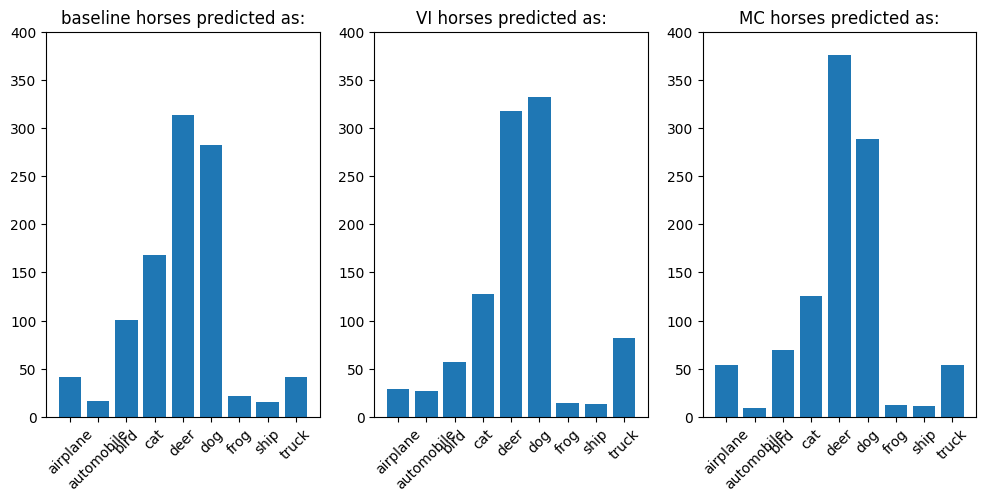

In [39]:
plt.figure(figsize=(12,5))
plt.subplot(1,3,1)
pred=np.argmax(model.predict(x_test_unknown),axis=1)
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
plt.bar(np.unique(pred_label,return_counts=True)[0],np.unique(pred_label,return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("baseline horses predicted as:")
plt.ylim([0,400])

plt.subplot(1,3,2)
SET=x_test_unknown
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred[i]=np.argmax(np.mean(preds,axis=0))#mean over n runs of every proba class
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
plt.bar(np.unique(pred_label,return_counts=True)[0],np.unique(pred_label,return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("VI horses predicted as:")
plt.ylim([0,400])

plt.subplot(1,3,3)
SET=x_test_unknown
pred=np.zeros((len(SET),1))
for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred[i]=np.argmax(np.mean(preds,axis=1))#mean over n runs of every proba class
pred_label=np.array([labels_no_horse[np.int(pred[i])] for i in range(0,len(pred))])
plt.bar(np.unique(pred_label,return_counts=True)[0],np.unique(pred_label,return_counts=True)[1])
plt.xticks(rotation=45)
plt.title("MC horses predicted as:")
plt.ylim([0,400])
plt.show()

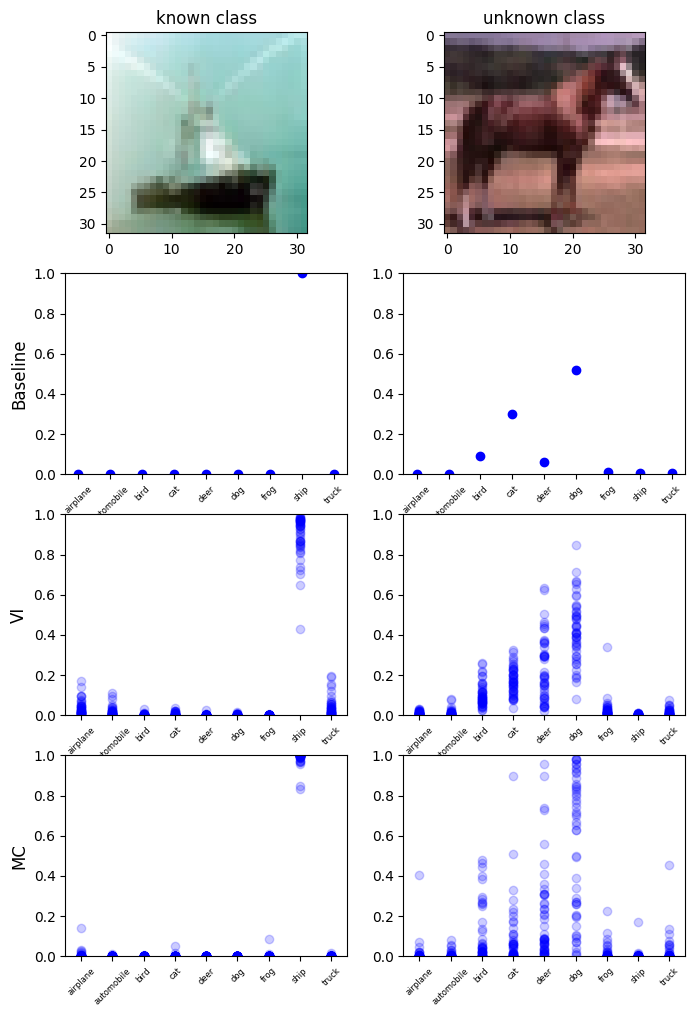

In [40]:
np.random.seed(282)
random_sample_known=np.random.choice(range(0,len(x_test_known)),1)
random_sample_unknown=np.random.choice(range(0,len(x_test_unknown)),1)
plt.figure(figsize=(8,12))
plt.subplot(4,2,1)
plt.imshow(np.squeeze(np.array(((((x_test_known[random_sample_known])/2)+0.5)*255),dtype="uint8")))
plt.title("known class")
plt.subplot(4,2,2)
plt.imshow(np.squeeze(np.array(((((x_test_unknown[random_sample_unknown])/2)+0.5)*255),dtype="uint8")))
plt.title("unknown class")

plt.subplot(4,2,3)
plt.scatter(range(0,9),model.predict(x_test_known[random_sample_known]),c="blue")
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=6)
plt.xticks(rotation=45)
plt.ylabel("Baseline",fontsize=12)

plt.ylim([0,1])
plt.subplot(4,2,4)
plt.scatter(range(0,9),model.predict(x_test_unknown[random_sample_unknown]),c="blue")
plt.ylim([0,1])
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=6)
plt.xticks(rotation=45)
plt.subplot(4,2,5)
for i in range(0,50):
  plt.scatter(range(0,9),model_vi.predict(x_test_known[random_sample_known]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=6)
plt.xticks(rotation=45)
plt.ylim([0,1])
plt.ylabel("VI",fontsize=12)


plt.subplot(4,2,6)
for i in range(0,50):
  plt.scatter(range(0,9),model_vi.predict(x_test_unknown[random_sample_unknown]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=6)
plt.xticks(rotation=45)
plt.ylim([0,1])
plt.subplot(4,2,7)
for i in range(0,50):
  plt.scatter(range(0,9),model_mc_pred([x_test_known[random_sample_known],1]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=6)
plt.xticks(rotation=45)
plt.ylim([0,1])
plt.ylabel("MC",fontsize=12)
plt.subplot(4,2,8)
for i in range(0,50):
  plt.scatter(range(0,9),model_mc_pred([x_test_unknown[random_sample_unknown],1]),c="blue",alpha=0.2)
plt.xticks(range(0,9),labels=labels_no_horse,fontsize=6)
plt.xticks(rotation=45)
plt.ylim([0,1])
plt.show()

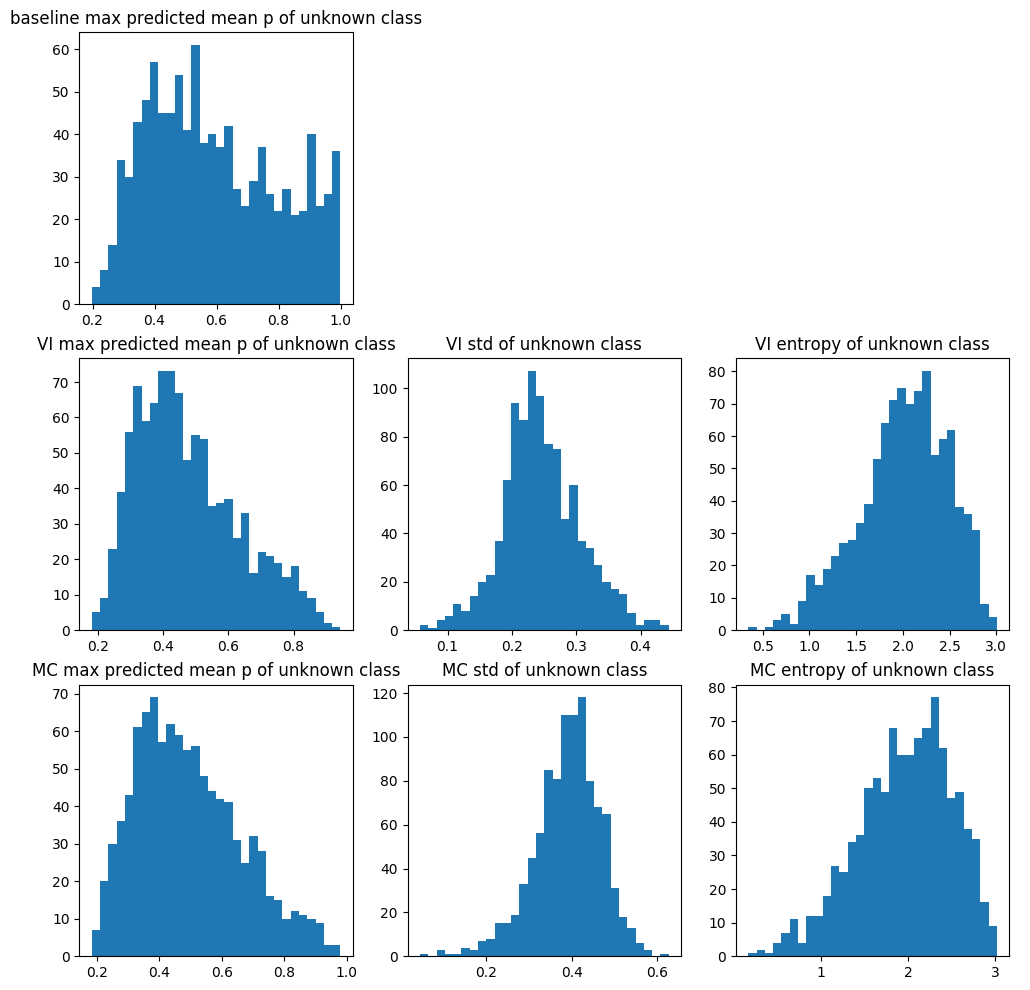

In [41]:

## look at the means sd and entropy of the true horses of the testset,
## here we want to see a hight uncertainty

pred=model.predict(x_test_unknown)
pred_uk=np.max(pred,axis=1)

plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.hist(pred_uk,bins=30)
plt.title("baseline max predicted mean p of unknown class")
plt.subplot(3,3,2)
plt.axis("off")
plt.subplot(3,3,3)
plt.axis("off")

SET=x_test_unknown
pred=np.zeros((len(SET),1))
pred_std_uk=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))
entropy_uk = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means_uk[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std_uk[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_uk[i] = -np.sum( pred_means_uk[i] * np.log2(pred_means_uk[i] + 1E-14)) #Numerical Stability

plt.subplot(3,3,4)
plt.hist(np.max(pred_means_uk,axis=1),bins=30)
plt.title("VI max predicted mean p of unknown class")
plt.subplot(3,3,5)
plt.hist(pred_std_uk,bins=30)
plt.title("VI std of unknown class")
plt.subplot(3,3,6)
plt.hist(entropy_uk,bins=30)
plt.title("VI entropy of unknown class")



SET=x_test_unknown
pred=np.zeros((len(SET),1))
pred_std_uk=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))
entropy_uk = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_means_uk[i]= np.mean(preds,axis=1)
  pred[i]=np.argmax(np.mean(preds,axis=1))
  pred_std_uk[i]= np.sqrt(np.sum(np.var(preds, axis=1)))
  entropy_uk[i] = -np.sum( pred_means_uk[i] * np.log2(pred_means_uk[i] + 1E-14)) #Numerical Stability

plt.subplot(3,3,7)
plt.hist(np.max(pred_means_uk,axis=1),bins=30)
plt.title("MC max predicted mean p of unknown class")
plt.subplot(3,3,8)
plt.hist(pred_std_uk,bins=30)
plt.title("MC std of unknown class")
plt.subplot(3,3,9)
plt.hist(entropy_uk,bins=30)
plt.title("MC entropy of unknown class")
plt.show()


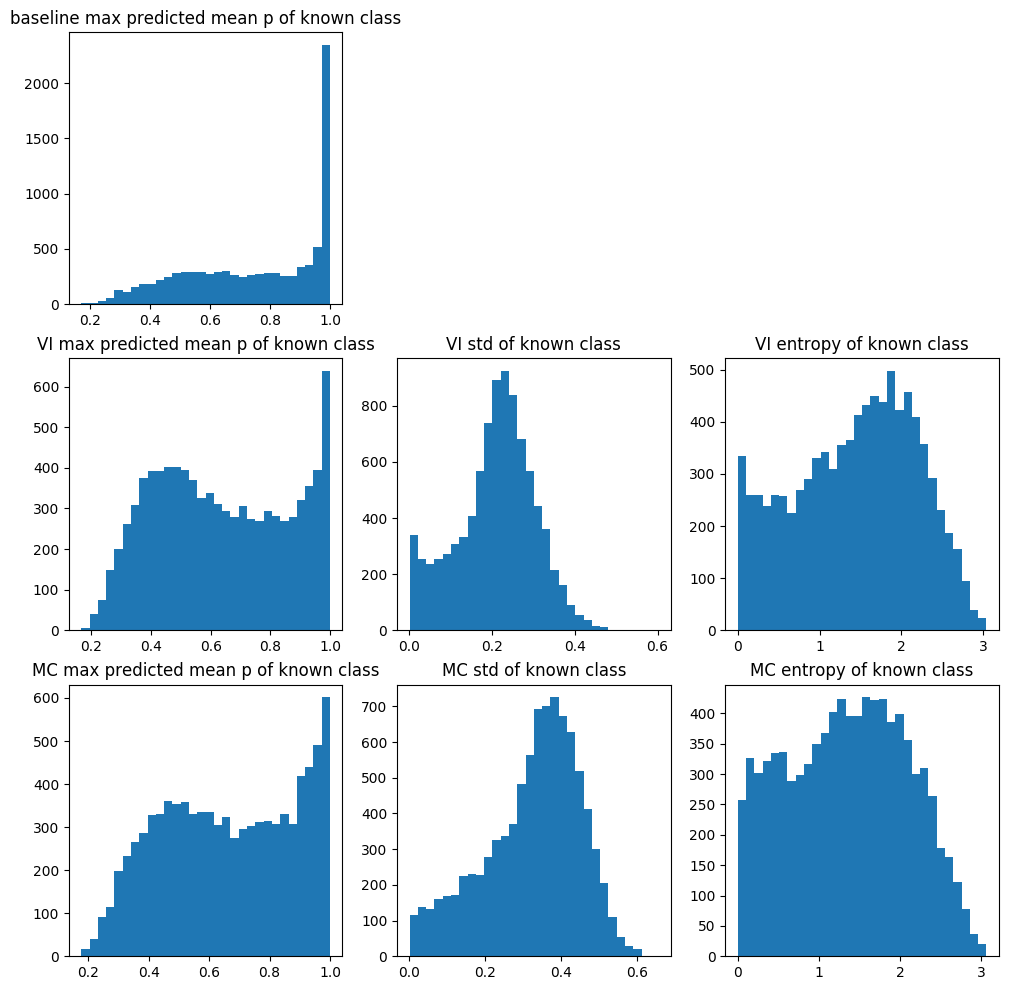

In [42]:
## look at the means sd and entropy of the known classes of the testset,
## here we want to see a low uncertainty

pred=model.predict(x_test_known)
pred_uk=np.max(pred,axis=1)

plt.figure(figsize=(12,12))
plt.subplot(3,3,1)
plt.hist(pred_uk,bins=30)
plt.title("baseline max predicted mean p of known class")
plt.subplot(3,3,2)
plt.axis("off")
plt.subplot(3,3,3)
plt.axis("off")

SET=x_test_known
pred=np.zeros((len(SET),1))
pred_std_uk=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))
entropy_uk = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means_uk[i]= np.mean(preds,axis=0)
  pred[i]=np.argmax(np.mean(preds,axis=0))
  pred_std_uk[i]= np.sqrt(np.sum(np.var(preds, axis=0)))
  entropy_uk[i] = -np.sum( pred_means_uk[i] * np.log2(pred_means_uk[i] + 1E-14)) #Numerical Stability

plt.subplot(3,3,4)
plt.hist(np.max(pred_means_uk,axis=1),bins=30)
plt.title("VI max predicted mean p of known class")
plt.subplot(3,3,5)
plt.hist(pred_std_uk,bins=30)
plt.title("VI std of known class")
plt.subplot(3,3,6)
plt.hist(entropy_uk,bins=30)
plt.title("VI entropy of known class")



SET=x_test_known
pred=np.zeros((len(SET),1))
pred_std_uk=np.zeros((len(SET),1))
pred_means_uk=np.zeros((len(SET),9))
entropy_uk = np.zeros((len(SET),1))

for i in tqdm(range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_means_uk[i]= np.mean(preds,axis=1)
  pred[i]=np.argmax(np.mean(preds,axis=1))
  pred_std_uk[i]= np.sqrt(np.sum(np.var(preds, axis=1)))
  entropy_uk[i] = -np.sum( pred_means_uk[i] * np.log2(pred_means_uk[i] + 1E-14)) #Numerical Stability

plt.subplot(3,3,7)
plt.hist(np.max(pred_means_uk,axis=1),bins=30)
plt.title("MC max predicted mean p of known class")
plt.subplot(3,3,8)
plt.hist(pred_std_uk,bins=30)
plt.title("MC std of known class")
plt.subplot(3,3,9)
plt.hist(entropy_uk,bins=30)
plt.title("MC entropy of known class")
plt.show()


## Filter our preds with pmax and p_mean

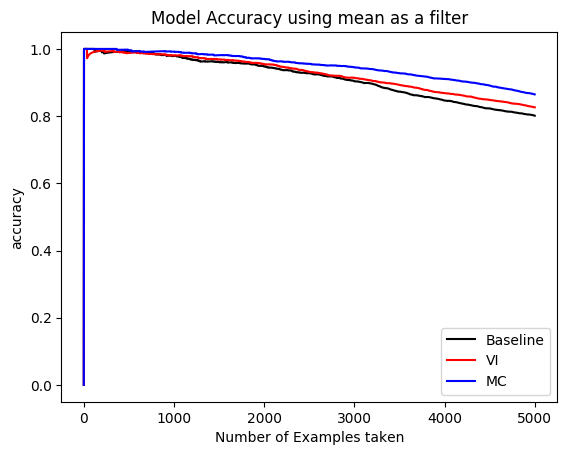

In [115]:
nr_of_best=5000

pred=model.predict(x_test)
pred=np.max(pred,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))
certainty_idx = certainty_idx[::-1]#reverse

pred=model.predict(x_test)
acc_nbest = np.zeros((nr_of_best))
for j in (range(1,nr_of_best)):
  pred_am=np.argmax(pred[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=np.sum(pred_label==true_label)/len(pred_label)

plt.plot(acc_nbest,c="black")
plt.title('Model Accuracy using mean as a filter')
plt.ylabel('accuracy')
plt.xlabel('Number of Examples taken')


SET=x_test
pred=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))

for i in (range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means[i]= np.mean(preds,axis=0)

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))
certainty_idx = certainty_idx[::-1]#reverse


acc_nbest = np.zeros((nr_of_best))
for j in (range(1,nr_of_best)):
  pred_am=np.argmax(pred_means[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=(np.sum(pred_label==true_label)/len(pred_label))
  
plt.plot(acc_nbest,c="red")



SET=x_test
pred=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))

for i in (range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_means[i]= np.mean(preds,axis=1)

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))
certainty_idx = certainty_idx[::-1]#reverse


acc_nbest = np.zeros((nr_of_best))
for j in (range(1,nr_of_best)):
  pred_am=np.argmax(pred_means[certainty_idx[0:j]],axis=1)
  pred_label=np.array([labels_no_horse[np.int(pred_am[i])] for i in range(0,len(pred_am))])
  tmp=y_test[certainty_idx[0:j]]
  true_label=np.array([labels[np.int(tmp[i])] for i in range(0,len(tmp))])
  acc_nbest[j]=(np.sum(pred_label==true_label)/len(pred_label))
  
plt.plot(acc_nbest,c="blue")
plt.legend(['Baseline', 'VI',"MC"], loc='lower right')
plt.show()



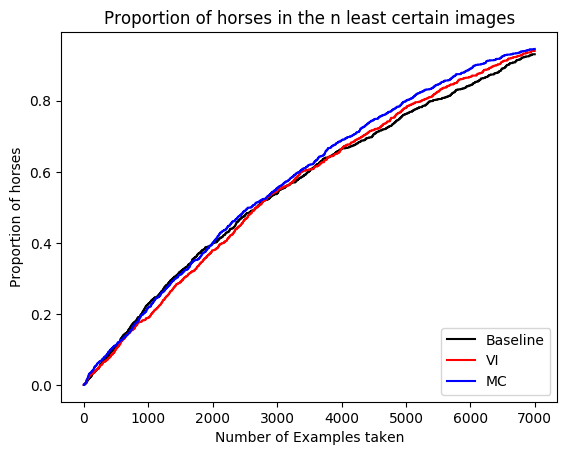

In [116]:
#what is the proportion of horses if we take the 7000 least certain images

nr_of_samples=7000

pred=model.predict(x_test)
pred=np.max(pred,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))


proportion_of_horses = np.zeros((nr_of_samples))
for j in (range(1,nr_of_samples)):
  proportion_of_horses[j]=np.sum(y_test[certainty_idx[0:j]]==7)/1000
  #
plt.plot(proportion_of_horses,c="black")
plt.title('Proportion of horses in the n least certain images')
plt.ylabel('Proportion of horses')
plt.xlabel('Number of Examples taken')


SET=x_test
pred=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))

for i in (range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_vi.predict(multi_img)
  pred_means[i]= np.mean(preds,axis=0)

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))


proportion_of_horses = np.zeros((nr_of_samples))
for j in (range(1,nr_of_samples)):
  proportion_of_horses[j]=np.sum(y_test[certainty_idx[0:j]]==7)/1000
plt.plot(proportion_of_horses,c="red")


SET=x_test
pred=np.zeros((len(SET),1))
pred_means=np.zeros((len(SET),9))

for i in (range(0,len(SET))):
  multi_img=np.tile(SET[i],(50,1,1,1))
  preds=model_mc_pred([multi_img,1])
  pred_means[i]= np.mean(preds,axis=1)

pred=np.max(pred_means,axis=1)
certainty_idx = np.argsort(pred.reshape(len(pred)))


proportion_of_horses = np.zeros((nr_of_samples))
for j in (range(1,nr_of_samples)):
  proportion_of_horses[j]=np.sum(y_test[certainty_idx[0:j]]==7)/1000
  
plt.plot(proportion_of_horses,c="blue")
plt.legend(['Baseline', 'VI',"MC"], loc='lower right')
plt.show()







### Use the entropy and the total standart deviation as a filter?

<img src="https://raw.githubusercontent.com/tensorchiefs/dl_book/master/imgs/paper-pen.png" width="60" align="left" />  


*Exercise 1: Change the code for the filtering and use the predicted entropy and the standart deviation as a filter. Note that a high value for the entropy and the standart deviation means the prediction is uncertain. Which model has the best accuracy if we take the best 3000 predictions?*